# Task 4 - Email Spam Detection 

<img src="spam.jpg" alt="Sample Image" width="800" height="700">

### Import Module

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

# Loading the Dataset

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# get necessary columns for processing
df = df[['v2', 'v1']]
df = df.rename(columns={'v2': 'messages', 'v1': 'label'})
df.head()

,messages,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [17]:
df.shape

(5572, 3)

In [6]:
# check for null values
df.isnull().sum()

messages    0
label       0
dtype: int64

In [26]:
df["messages"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### The raw E-Mails have a lot of characters beside of the ones of the alphabet, which might provoke issues later. Therefore, the E-Mails will be cleaned.

In [30]:
df1 = df.copy()

In [31]:
from nltk.tokenize import RegexpTokenizer

def clean_text(text, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a text with RegexpTokenizer
    text = text.lower()
    tokens = reg.tokenize(text)
    return " ".join(tokens)

In [33]:
print('Before cleaning: \n',df1['messages'][0])
print()
print('After cleaning: \n',clean_text(df1['messages'][0]))


Before cleaning: 
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

After cleaning: 
 go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


In [34]:
# Create a new column with the cleaned messages
df1['clean_text'] = df1['messages'].apply(lambda text: clean_text(text))
# Display the result
df1.head()

,messages,label,clean_text
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final ...
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i don t think he goes to usf he lives arou...


In [35]:
df1["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

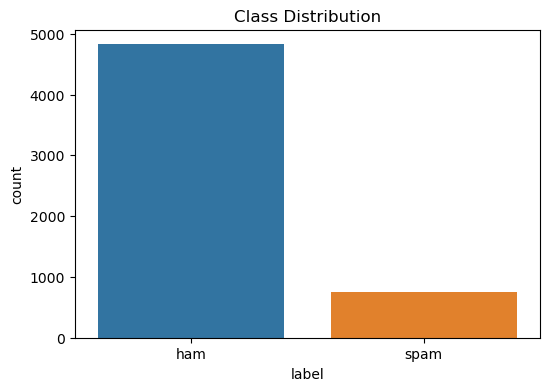

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df1, x='label')
plt.title('Class Distribution')
plt.show()

#### Problem: We have a dataset with 'ham' and 'spam' email labels, and we need to convert these labels into numeric values, with 'ham' as 0 and 'spam' as 1, for machine learning.

 Solution: The code loads the dataset, defines a mapping function, and creates a new column 'label_numeric' to represent 'ham' as 0 and 'spam' as 1, making the data ready for machine learning tasks.

In [37]:
df1['label_numeric'] = df1['label'].map({'ham': 0, 'spam': 1})

In [38]:
df1.head()

,messages,label,clean_text,label_numeric
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...,0
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final ...,1
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i don t think he goes to usf he lives arou...,0


In [42]:
df1.duplicated().sum()

403

#### Data Size: Our dataset is large and the number of duplicate rows is relatively small (400 out of 5572), removing duplicates may have a minimal impact on the overall dataset size.

In [45]:
df1.shape

(5572, 4)

In [46]:
df2.shape

(5169, 4)

In [47]:
print("Shape of dataset before contains duplicates: ",df1.shape )
df2 = df1.drop_duplicates()
print("Shape of dataset after removing duplicates: ",df2.shape )

Shape of dataset before contains duplicates:  (5572, 4)
Shape of dataset after removing duplicates:  (5169, 4)


In [53]:
df2['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

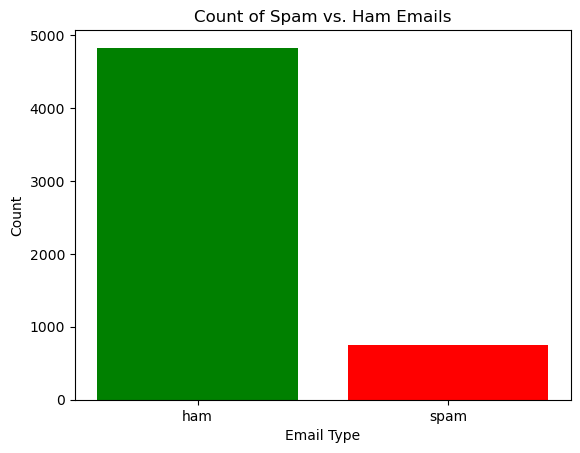

In [54]:
# Count the number of spam and ham emails
counts = df['label'].value_counts()

# Create a bar chart
plt.bar(counts.index, counts.values, color=[ 'green','red'])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Count of Spam vs. Ham Emails')
plt.show()


### The dataset is imbalanced, with 4,516 'ham' emails and only 653 'spam' emails. This can lead to biased model performance.

In [55]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X = tfidf_vectorizer.fit_transform(df2['clean_text']).toarray()
y = df2['label_numeric']

#### Solution Using SMOTE (Synthetic Minority Over-sampling Technique):

To address the imbalanced dataset issue, one effective approach is to apply the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE is a resampling technique that aims to balance the class distribution by generating synthetic examples for the minority class.

In [56]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))

Class distribution before SMOTE: Counter({0: 4516, 1: 653})
Class distribution after SMOTE: Counter({0: 4516, 1: 4516})


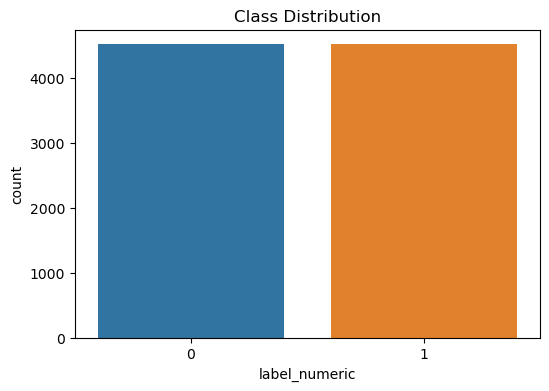

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df2, x=y_resampled)
plt.title('Class Distribution')
plt.show()

# Model Training

In [61]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

#  Model comparison

In [86]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 18.49 sec
Gradient Boosting    trained in 192.03 sec
XGBoost              trained in 66.84 sec
MultinomialNB        trained in 0.16 sec
Logistic Regr.       trained in 1.17 sec
KNN                  trained in 0.07 sec
Decision Tree        trained in 14.31 sec
SVM (Linear)         trained in 0.25 sec
SVM (RBF)            trained in 65.33 sec


In [90]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [91]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,SVM (Linear),0.998893,0.25
1,SVM (RBF),0.998340,65.33
2,Random Forest,0.995573,18.49
3,KNN,0.995019,0.07
4,XGBoost,0.992252,66.84
5,Logistic Regr.,0.990592,1.17
6,MultinomialNB,0.989485,0.16
7,Gradient Boosting,0.982844,192.03
8,Decision Tree,0.980077,14.31


## Confusion Matrix of each model

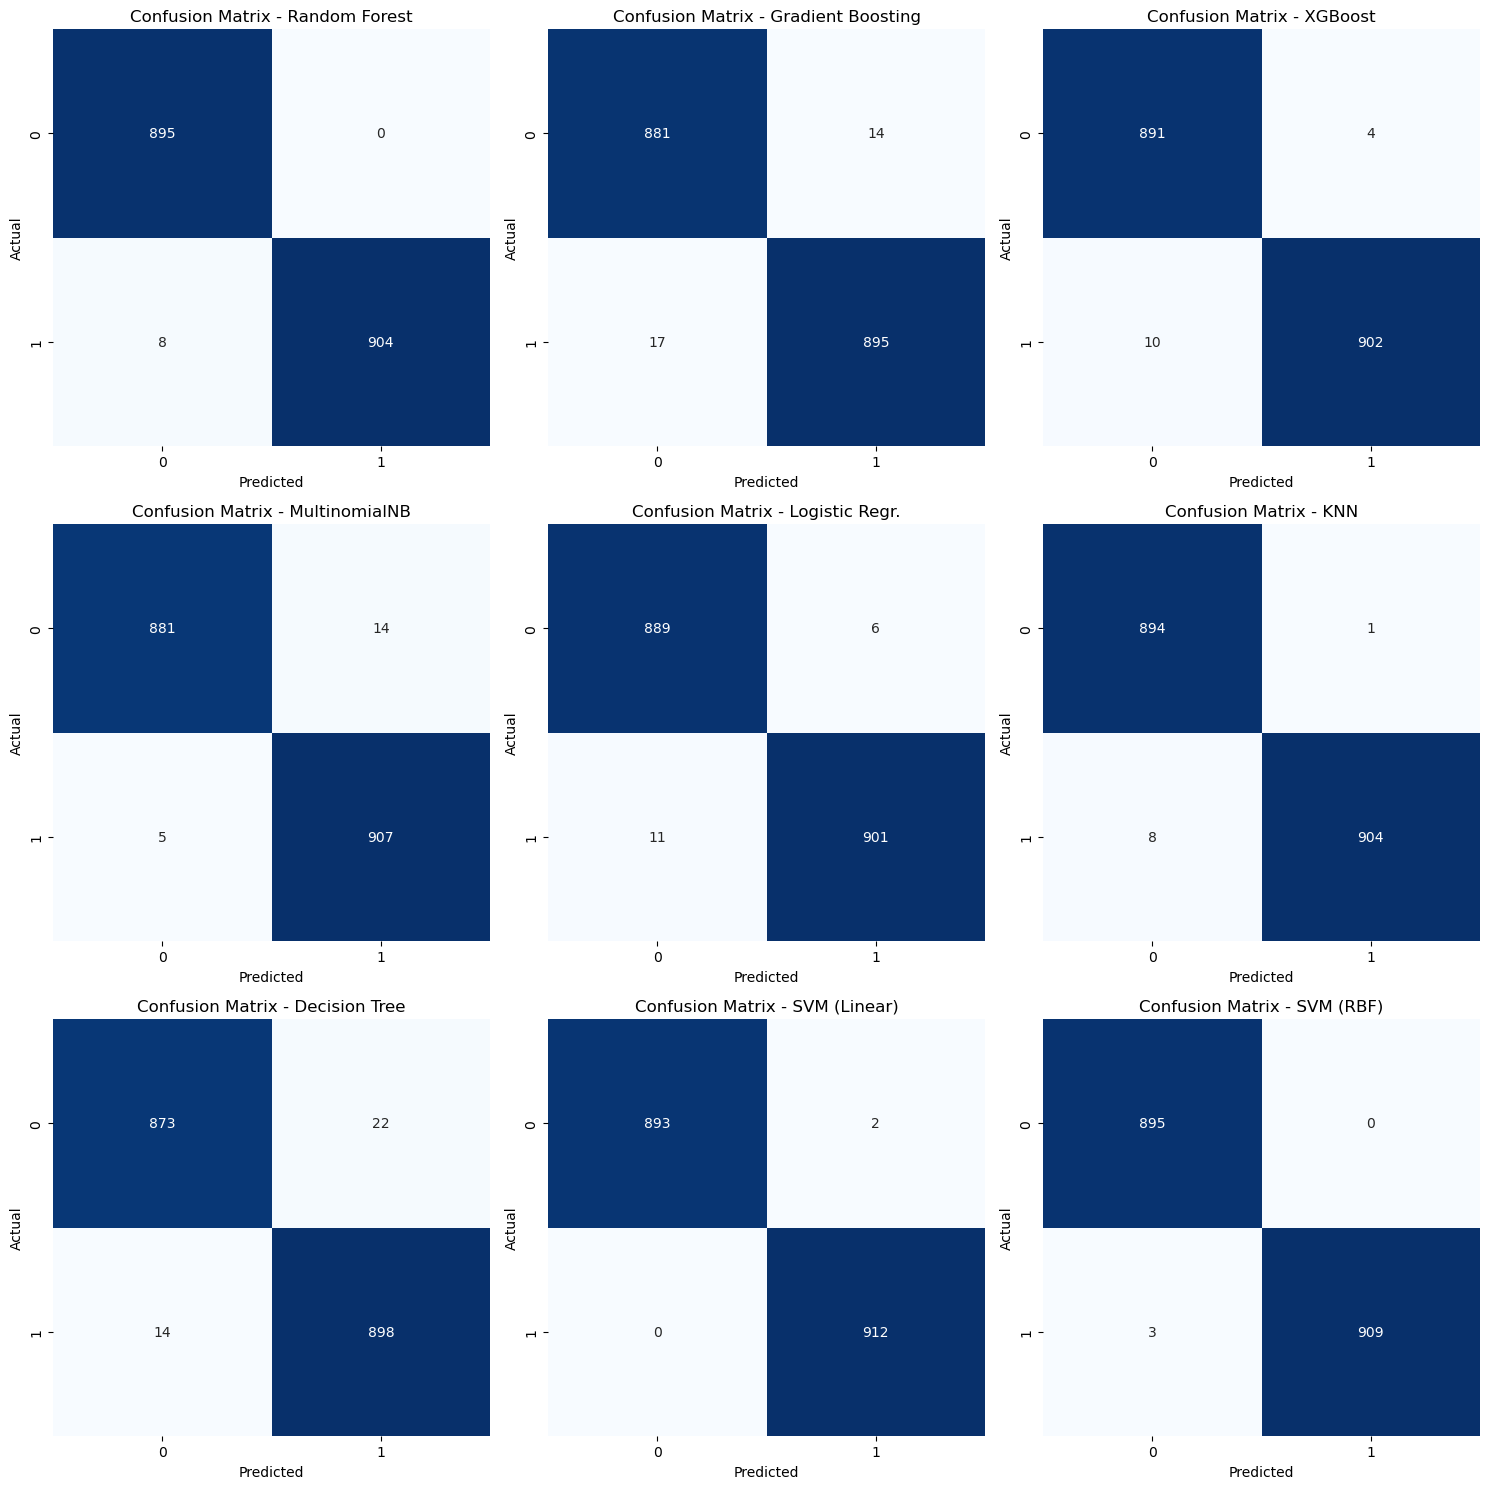

In [93]:
def plot_confusion_matrix(model, name, ax):
    y_pred = model['model'].predict(X_test)  # Replace X_test with your test data
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Assuming you have trained models and got predictions for each model
fig, axes = plt.subplots(3, 3, figsize=(15, 5*3))

if num_models == 1:
    axes = [axes]

for (name, model), ax in zip(models.items(), axes.flat):
    plot_confusion_matrix(model, name, ax)

plt.tight_layout()
plt.show()

## Classification Model of each Model

In [94]:
from sklearn.metrics import classification_report

# Assuming you have trained models and got predictions for each model
for name, model in models.items():
    y_pred = model['model'].predict(X_test)  # Replace X_test with your test data
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    print("=" * 50)

Model: Random Forest
Confusion Matrix:
[[895   0]
 [  8 904]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       895
           1       1.00      0.99      1.00       912

    accuracy                           1.00      1807
   macro avg       1.00      1.00      1.00      1807
weighted avg       1.00      1.00      1.00      1807

Model: Gradient Boosting
Confusion Matrix:
[[881  14]
 [ 17 895]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       895
           1       0.98      0.98      0.98       912

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807

Model: XGBoost
Confusion Matrix:
[[891   4]
 [ 10 902]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00     

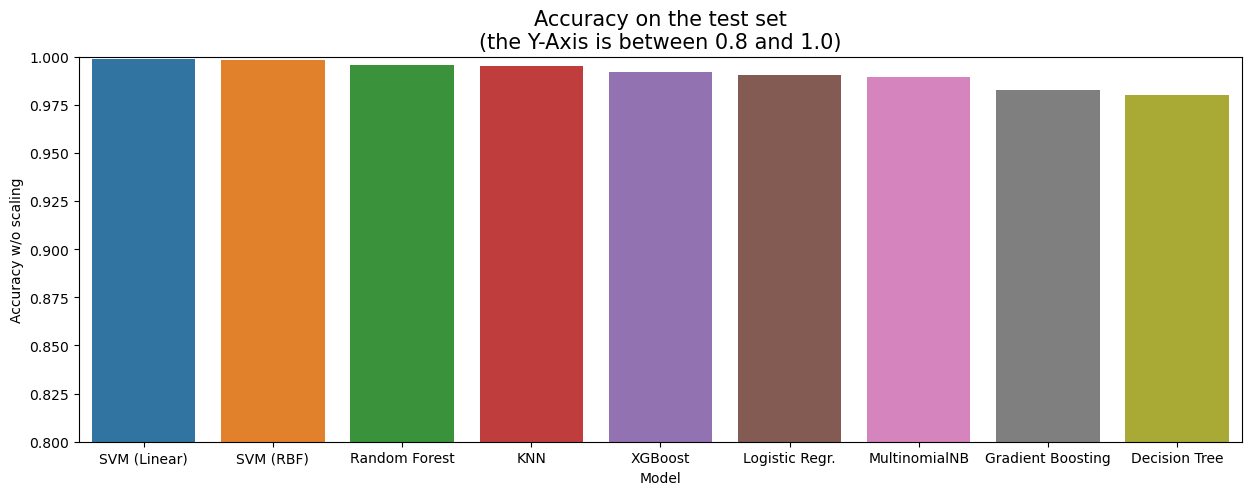

In [95]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

## SVM (Linear) gives the best result on the test set. 